In [2]:
import cv2
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models, preprocessing, callbacks, Sequential

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
## Config
DATA_PATH = '/content/gdrive/My Drive/CS4243'
TEST_DATA_PATH = DATA_PATH + '/test'
TRAIN_DATA_PATH = DATA_PATH + '/train'
PREPROCESSED_DATA_PATH = DATA_PATH + '/preprocessed'
PREPROCESSED_TRAIN_DATA_PATH = PREPROCESSED_DATA_PATH + '/train'
PREPROCESSED_TEST_DATA_PATH = PREPROCESSED_DATA_PATH + '/test'
SAMPLE_DATA = '/zzqtgk-0.png'

IMAGE_SHAPE = (256, 64) # (width, height)
IMG_WIDTH, IMG_HEIGHT = IMAGE_SHAPE

BATCH_SIZE = 32
CHARACTERS = '0123456789abcdefghijklmnopqrstuvwxyz'
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
MAX_LENGTH = 8 # determined from data labels

In [5]:
# Mapping Chars to Nums
char_to_num = layers.StringLookup(vocabulary=list(CHARACTERS), mask_token=None)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

print(f"Vocab: {char_to_num.get_vocabulary()}")

Vocab: ['[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [7]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    # Load image in grayscale mode
    img = load_img(image_path, color_mode='grayscale')
    # Resize to the defined IMAGE_SHAPE
    img = img.resize((IMG_WIDTH, IMG_HEIGHT))
    # Convert image to numpy array and normalize pixel values
    img_array = img_to_array(img) / 255.0
    return img_array

def load_and_preprocess_data(data_path):
    data, labels = [], []
    for filename in os.listdir(data_path):
        label = filename.split('-')[0]
        image_path = os.path.join(data_path, filename)
        img = preprocess_image(image_path)
        data.append(img)
        labels.append(label)
    return np.array(data), np.array(labels)

# Preprocess the training and testing data
x_train, y_train = load_and_preprocess_data(TRAIN_DATA_PATH)
x_test, y_test = load_and_preprocess_data(TEST_DATA_PATH)

print(f'Training data shape: {x_train.shape}, Training labels: {len(y_train)}')
print(f'Testing data shape: {x_test.shape}, Testing labels: {len(y_test)}')

Training data shape: (8010, 64, 256, 1), Training labels: 8010
Testing data shape: (2000, 64, 256, 1), Testing labels: 2000


In [8]:
from tensorflow.keras.layers import StringLookup

# Function to encode labels into integer sequences
def encode_labels(labels):
    # Encode each character in each label
    encoded = [[CHAR_TO_INDEX[char] for char in label] for label in labels]
    return encoded

def pad_sequences(sequences):
    # Pad the sequences to the same length (MAX_LENGTH)
    return tf.keras.preprocessing.sequence.pad_sequences(
        sequences, maxlen=MAX_LENGTH, padding='post'
    )

y_train_encoded = encode_labels(y_train)
y_train_padded = pad_sequences(y_train_encoded)

y_test_encoded = encode_labels(y_test)
y_test_padded = pad_sequences(y_test_encoded)

print(f'Example padded label: {y_train_padded[0]}')

Example padded label: [15 35  2 13 19  0  0  0]


In [9]:
from tensorflow.keras import layers, Model

def build_model():
    input_img = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))

    # Convolutional layers with Dropout
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    # RNN layer for sequence modeling
    x = layers.Reshape((-1, x.shape[2] * x.shape[3]))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.3))(x)

    # Output layer
    output = layers.Dense(len(CHARACTERS) + 1, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_img, outputs=output)
    return model

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 256, 1)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 64, 256, 32)         │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 32, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 128, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 128, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 16, 4096)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 16, 256)             │       4,326,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16, 37)              │           9,509 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,354,725 (16.61 MB)

 Trainable params: 4,354,725 (16.61 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def ctc_loss(y_true, y_pred):
    batch_size = tf.shape(y_pred)[0]

    # Input length (after CNN + pooling)
    input_length = tf.fill([batch_size, 1], y_pred.shape[1])

    # Label length (actual length of each label sequence)
    label_length = tf.fill([batch_size, 1], MAX_LENGTH)

    # Compute CTC loss
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

model.compile(optimizer='adam', loss=ctc_loss)

Epoch 1/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 410s 2s/step - loss: 26.4902 - val_loss: 28.2500
Epoch 2/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 433s 2s/step - loss: 24.9769 - val_loss: 24.8900
Epoch 3/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 399s 2s/step - loss: 24.4575 - val_loss: 24.3265
Epoch 4/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - loss: 24.1009 - val_loss: 23.9509
Epoch 5/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - loss: 23.8549 - val_loss: 23.8325
Epoch 6/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - loss: 23.4986 - val_loss: 23.6385
Epoch 7/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 452s 2s/step - loss: 23.1857 - val_loss: 23.5749
Epoch 8/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - loss: 22.8579 - val_loss: 23.5438
Epoch 9/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 438s 2s/step - loss: 22.6146 - val_loss: 23.5122
Epoch 10/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - loss: 22.1721 - val_loss: 23.6302
Epoch 11/50
251/251 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - loss: 21.7267 - val_loss: 23.7412
Epoch 12/50
251/251

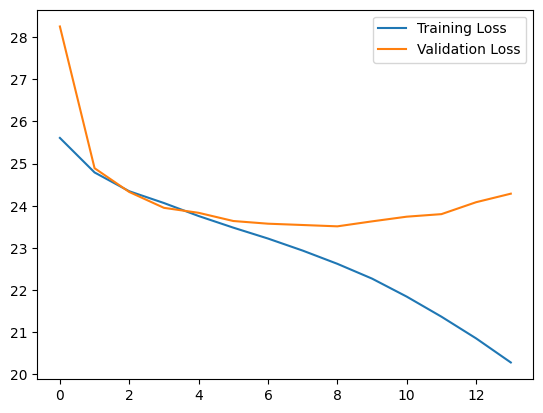

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    x_train,  # Only images as input
    y_train_padded,  # Labels (padded)
    validation_data=(x_test, y_test_padded),
    batch_size=BATCH_SIZE,
    epochs=50,
    callbacks=[early_stopping]
)

# Plot training results
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [12]:
def decode_predictions(predictions):
    # Use CTC decoding to extract the predicted sequences
    decoded = tf.keras.backend.ctc_decode(
        predictions, input_length=np.ones(predictions.shape[0]) * predictions.shape[1]
    )[0][0]
    # Convert each sequence of integers to corresponding characters
    return [
        ''.join([CHARACTERS[pred] for pred in sequence if pred != -1])
        for sequence in decoded.numpy()
    ]

def calculate_accuracy(y_true, y_pred):
    total_chars = 0
    correct_chars = 0
    correct_captchas = 0

    for i in range(len(y_true)):
        # Compare each predicted CAPTCHA with the ground truth
        if y_true[i] == y_pred[i]:
            correct_captchas += 1  # CAPTCHA matches perfectly

        # Calculate character-wise accuracy
        for j in range(min(len(y_true[i]), len(y_pred[i]))):
            total_chars += 1
            if y_true[i][j] == y_pred[i][j]:
                correct_chars += 1

    captcha_accuracy = correct_captchas / len(y_true)
    char_accuracy = correct_chars / total_chars

    return captcha_accuracy, char_accuracy

# Generate predictions
predictions = model.predict(x_test)
decoded_predictions = decode_predictions(predictions)

captcha_acc, char_acc = calculate_accuracy(y_test, decoded_predictions)
print(f"CAPTCHA Accuracy: {captcha_acc * 100:.2f}%")
print(f"Character Accuracy: {char_acc * 100:.2f}%")

# Compare with ground truth
for i in range(5):  # Display a few examples
    print(f'Prediction: {decoded_predictions[i]}, Ground Truth: {y_test[i]}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 406ms/step
CAPTCHA Accuracy: 0.00%
Character Accuracy: 3.23%
Prediction: g00, Ground Truth: n4oomt
Prediction: 00, Ground Truth: knrs2rq
Prediction: mx1, Ground Truth: 9k0r3u89
Prediction: i000, Ground Truth: zjalw
Prediction: wm000, Ground Truth: 5oqszg


In [13]:
model.save('/content/gdrive/My Drive/CS4243/captcha_model.h5')